## 需要的套件

In [1]:
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from matplotlib import font_manager as fm
from sklearn.preprocessing import StandardScaler
from xgboost.sklearn import XGBClassifier
from sklearn.svm import SVC, OneClassSVM
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation, Input
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

## DNN模型

In [2]:
class DNN:
    def __init__(self, input_shape): # 初始化模型
        self.model = Sequential([
            Input(shape=(input_shape,)),
            Dense(100, kernel_initializer='glorot_normal'),
            BatchNormalization(), Activation('relu'), Dropout(0.5),
            Dense(10, kernel_initializer='glorot_normal', use_bias=False),
            BatchNormalization(), Activation('relu'), Dropout(0.25),
            Dense(1, activation='sigmoid')
        ])
        self.model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', 'Recall'])

    def fit(self, X_train, Y_train, epochs=150, batch_size=32):
        reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=5, min_lr=0.0001)
        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        self.model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, callbacks=[reduce_lr, early_stopping], validation_split=0.2)

    def predict(self, X_test, batch_size=300):
        return np.round(self.model.predict(X_test, batch_size=batch_size)).flatten()

## 載入訓練數據(以big5讀檔)

In [3]:
def load_and_preprocess_data(train_file_path, test_file_path):
    train_df, test_df = pd.read_csv(train_file_path, encoding='big5'), pd.read_csv(test_file_path, encoding='big5')
    combined_df = pd.concat([train_df, test_df], ignore_index=True) # 合併訓練和測試數據集
    for column in ['婚姻狀況', '工作分類', '廠區代碼', '工作地點', '歸屬部門', '最高學歷', '畢業學校類別', '畢業科系類別']: # 如果存在指定的列，則進行one hot encoding
        if column in combined_df.columns:
            combined_df = pd.get_dummies(combined_df, columns=[column], dtype=int)

    combined_df = combined_df.drop(['婚姻狀況_-1', '工作分類_-1'], axis=1)

    # 將合併後的數據集拆回訓練集和測試集
    train_df, test_df = combined_df.iloc[:len(train_df)], combined_df.iloc[len(train_df):]
    X_train, Y_train = train_df.drop(['PerNo', 'PerStatus'], axis=1), train_df['PerStatus']
    X_test = test_df.drop(['PerNo', 'PerStatus'], axis=1)

    # 尺度轉換和數據平衡
    scaler = StandardScaler()
    X_train_scaled, X_test_scaled = scaler.fit_transform(X_train), scaler.transform(X_test)
    X_train_balanced, Y_train_balanced = SMOTE(random_state=42).fit_resample(X_train_scaled, Y_train)
    
    return X_train_balanced, Y_train_balanced, X_test_scaled, X_train.columns, test_df[['PerNo']]

## 預測並保存結果

In [4]:
def predict_and_save_results(model, X_test, ans, output_path):
    predictions = np.clip(model.predict(X_test), 0, 1)
    ans.assign(PerStatus=predictions).to_csv(output_path, index=False)
    print(f"Predictions saved to '{output_path}'")

## 顯示SHAP解釋模型

In [5]:
def generate_shap_summary(model, X_train_balanced, X_test_scaled, feature, model_name): # 生成SHAP圖
    explainer = shap.Explainer(model.model, X_train_balanced) if model_name == 'DNN' else shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_train_balanced)
    plt.title(f"{model_name} SHAP Summary", fontsize=16, fontweight="bold", loc="center")
    feature_values = shap_values[..., 1] if model_name in ['DecisionTree', 'RandomForest'] else shap_values
    shap.summary_plot(feature_values, X_train_balanced, feature_names=feature)

## 主程式

In [6]:
def main():
    # 加載和預處理數據
    X_train_balanced, Y_train_balanced, X_test_scaled, feature, ans = load_and_preprocess_data('processed_train.csv', 'processed_test.csv')
    
    # 訓練模型並進行預測
    models = {
        'DNN': DNN(input_shape=X_train_balanced.shape[1]),
        'DecisionTree': DecisionTreeClassifier(),
        'RandomForest': RandomForestClassifier(),
        'XGBoost': XGBClassifier(),
        'OneClassSVM': OneClassSVM(kernel='rbf')
    }

    for model_name, model in models.items():
        print(f'Training {model_name}...')
        model.fit(X_train_balanced, Y_train_balanced)
        predict_and_save_results(model, X_test_scaled, ans, f'{model_name}_predicted.csv')

        plt.rcParams['font.family'] = fm.FontProperties(fname=r'C:\Windows\Fonts\msyh.ttc').get_name()
        if model_name != 'OneClassSVM':
            generate_shap_summary(model, X_train_balanced, X_test_scaled, feature, model_name)

Training DNN...
Epoch 1/150
680/680 ━━━━━━━━━━━━━━━━━━━━ 2s 814us/step - Recall: 0.4759 - accuracy: 0.6083 - loss: 0.6719 - val_Recall: 0.4797 - val_accuracy: 0.4797 - val_loss: 0.7863 - learning_rate: 0.0010
Epoch 2/150
680/680 ━━━━━━━━━━━━━━━━━━━━ 0s 624us/step - Recall: 0.4041 - accuracy: 0.6744 - loss: 0.6056 - val_Recall: 0.4909 - val_accuracy: 0.4909 - val_loss: 0.8286 - learning_rate: 0.0010
Epoch 3/150
680/680 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - Recall: 0.3978 - accuracy: 0.6787 - loss: 0.5983 - val_Recall: 0.4872 - val_accuracy: 0.4872 - val_loss: 0.8197 - learning_rate: 0.0010
Epoch 4/150
680/680 ━━━━━━━━━━━━━━━━━━━━ 0s 639us/step - Recall: 0.4283 - accuracy: 0.6856 - loss: 0.5922 - val_Recall: 0.4983 - val_accuracy: 0.4983 - val_loss: 0.8119 - learning_rate: 0.0010
Epoch 5/150
680/680 ━━━━━━━━━━━━━━━━━━━━ 0s 615us/step - Recall: 0.4120 - accuracy: 0.6832 - loss: 0.5921 - val_Recall: 0.4859 - val_accuracy: 0.4859 - val_loss: 0.8172 - learning_rate: 0.0010
Epoch 6/150
680/680

PermutationExplainer explainer: 27193it [14:05, 31.53it/s]                           


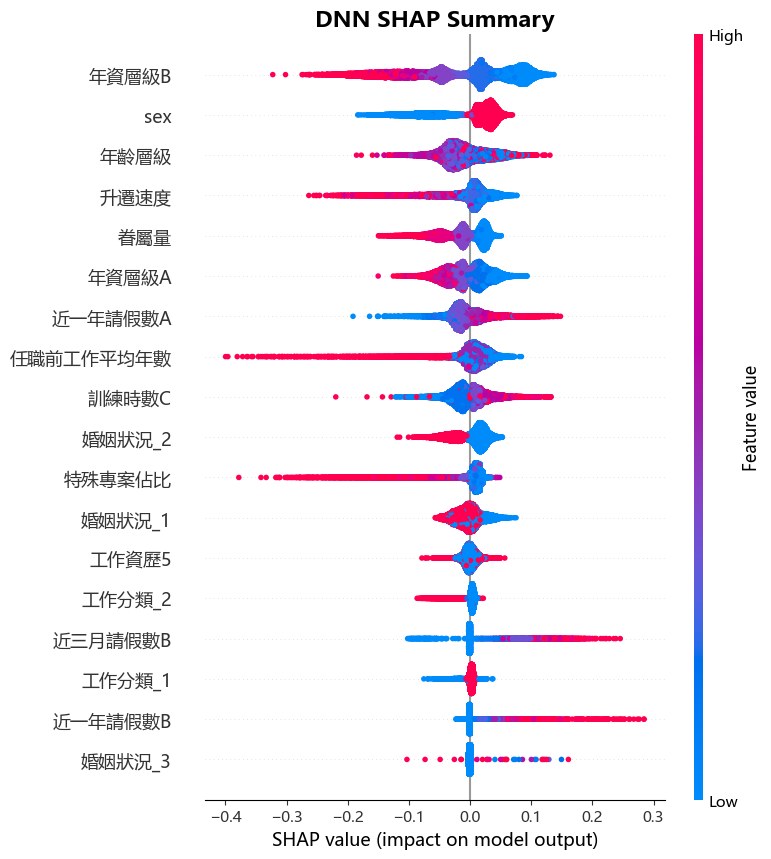

Training DecisionTree...
Predictions saved to 'DecisionTree_predicted.csv'


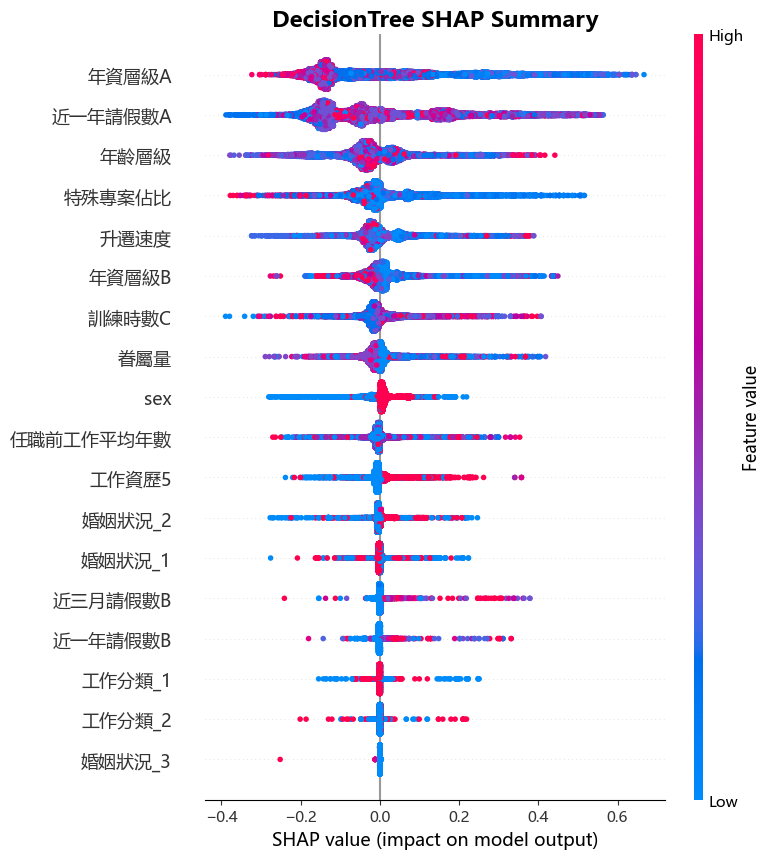

Training RandomForest...
Predictions saved to 'RandomForest_predicted.csv'


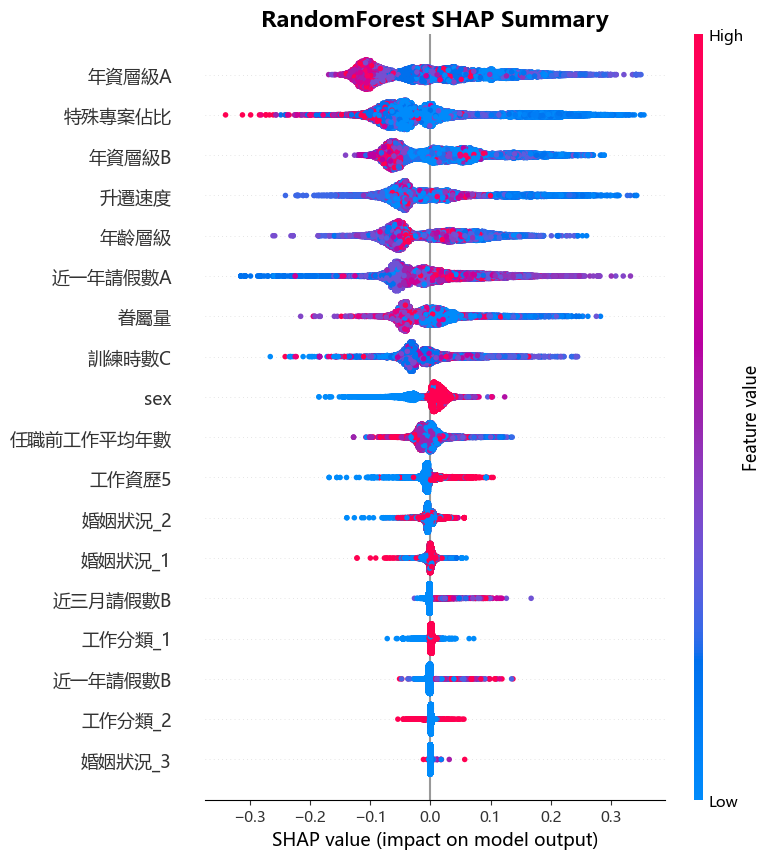

Training XGBoost...
Predictions saved to 'XGBoost_predicted.csv'


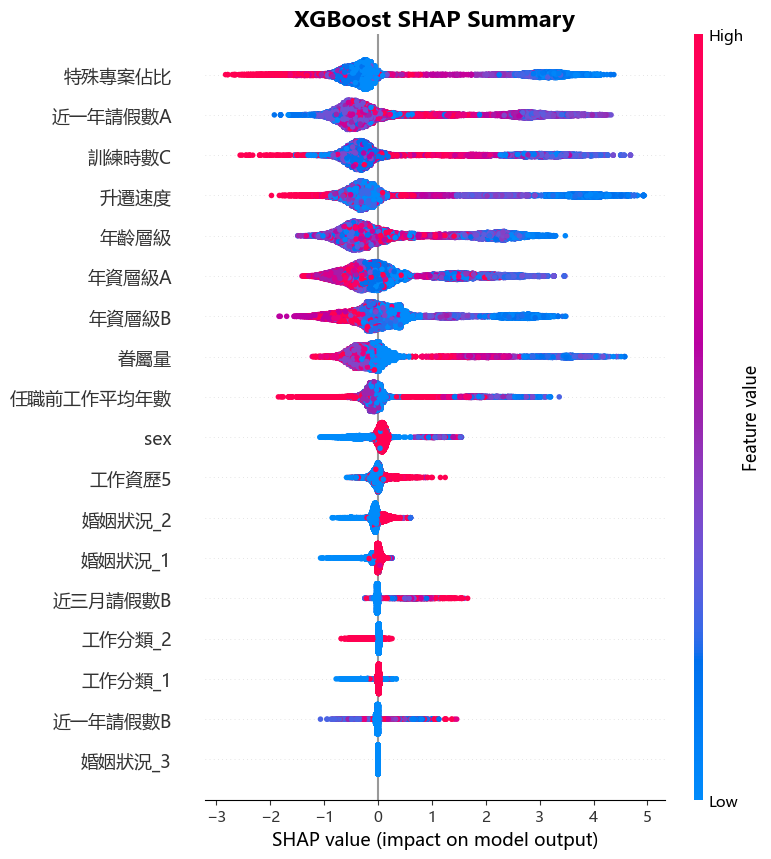

Training OneClassSVM...
Predictions saved to 'OneClassSVM_predicted.csv'


In [7]:
if __name__ == "__main__":
    main()